In [1]:
!pip install bayesian-optimization
import pandas as pd
from xgboost import XGBClassifier, cv
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
import numpy as np
sns.set_theme()


SEED=0


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# Load the dataset
- Load data from excel sheet
- Set X (independent variables) and y (dependent variables) 

In [2]:
dataset='Dragon'
data_path = './data/alvaDescDescriptors.txt'
na_values=['na']
df = pd.read_csv(data_path, sep="\t",  dtype={'pctapi': np.float64}, na_values=na_values)
smiles =  np.loadtxt("./data/smiles.txt", dtype='str')
df = df.drop(['No.', 'NAME'], axis=1)
df = df.set_index(smiles)
data_path = './data/master_4Mayhew.xlsx'
df_mor = pd.read_excel(data_path)
y=df_mor['label'] # labels, independent variables
X=df # features, dependent variables
X.columns = X.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
df.describe()

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
count,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,...,865.0,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000
mean,152.497214,8.130482,12.828913,22.149323,13.800939,25.139284,0.597289,1.017789,0.639164,1.143216,...,0.0,0.008478,0.057996,0.191137,2.080402,0.169246,0.417864,0.036698,2.093204,0.600119
std,66.919081,7.112818,5.985939,10.237872,6.521889,11.873281,0.110081,0.072288,0.152502,0.047199,...,0.0,0.152963,0.527725,1.114756,4.437306,0.316773,1.053596,0.089476,4.607502,1.360089
min,16.050000,3.210000,0.910100,1.952700,0.698900,1.856400,0.387050,0.909080,0.349450,0.928200,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106.140000,5.585152,8.778400,15.305400,9.454700,17.079600,0.527400,0.979383,0.576931,1.124658,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,144.240000,6.484286,12.192800,21.283500,13.238800,24.115800,0.571300,0.994537,0.615738,1.138492,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,184.310000,8.068235,15.982800,28.250700,17.307100,31.946200,0.636588,1.019995,0.658200,1.146753,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,532.520000,126.900000,42.281600,67.508700,44.767400,75.820500,1.580200,1.412100,3.039800,1.483150,...,0.0,3.500000,8.500000,12.000000,30.000000,0.913043,7.000000,0.500000,31.304952,9.949874


# Explore the dataset

## How many missing values?

In [96]:
print(f"Number of columns with all NaNs \n{(df.isna().mean(axis=0) == 1).value_counts()}")
print(f"\n Number of columns with >0.9 NaNs \n{(df.isna().mean(axis=0) > 0.9).value_counts()}")
print(f"\n Number of columns with a NaN \n{ len(df.columns[df.isna().any()].tolist())}")

Number of columns with all NaNs 
False    4179
dtype: int64

 Number of columns with >0.9 NaNs 
False    4179
dtype: int64

 Number of columns with a NaN 
1147


### Visualise number of NaNs in descriptors with missing values 

Text(0.5, 0, 'Percentage NaNs in descriptors with missing values')

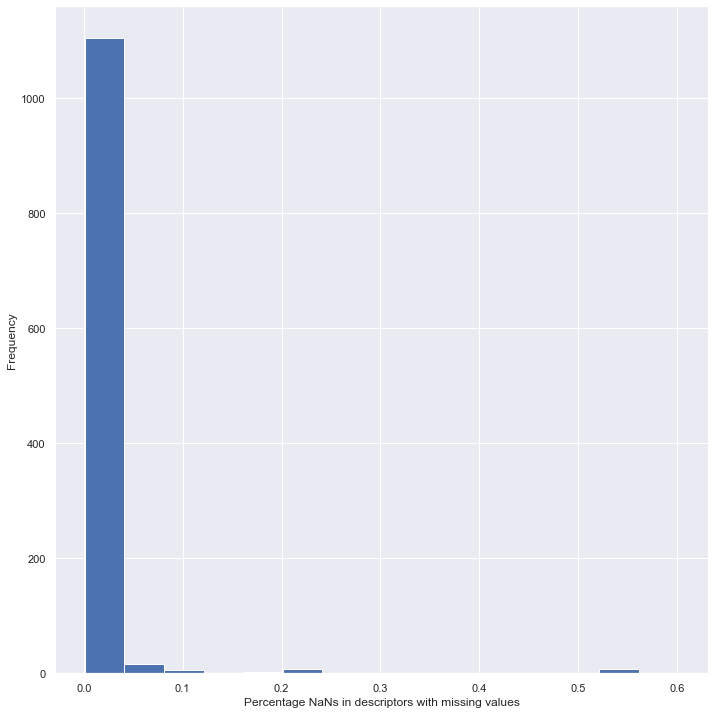

In [97]:
percs = df.isna().mean(axis=0)

ax = percs[(percs > 0)].plot.hist(bins=15)
plt.xlabel("Percentage NaNs in descriptors with missing values")

## Correlation between the descriptors

- degree to which features are related 
- https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

In [98]:
corrs = df.corr()

In [99]:
corrs.to_csv(f'results/correlations/descriptor-correlations-{dataset}.csv')  

### Extract correlation scores for important features

In [100]:
def corrs_important_features(model, X_test, model_name, nlargest=100, heatmap=14):
    feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
    top_100 = feature_imp.nlargest(100)
    important_df = df.loc[:,top_100.index]
    corrs = important_df.corr()
    
    print(f"Extracted correlation scores for most important {nlargest} features for {model_name}")
    corrs.to_csv(f'results/correlations/descriptor-corrs-top{nlargest}-{model_name}-{dataset}.csv')  
    
    # Print heatmap for top n
    print(f"Printing heatmap for most important {heatmap} features")
    
    top_10 = feature_imp.nlargest(heatmap)
    important_df_10 = df.loc[:,top_10.index]
    corrs_10 = important_df_10.corr()
    
    plt.figure(figsize = (16,16))
    heatmap = sns.heatmap(corrs_10, vmin=-1, vmax=1, annot=True)
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Preprocessing

In [101]:
# Correlation

corrs = df.corr()
# select upper traingle of correlation matrix
upper = corrs.where(np.triu(np.ones(corrs.shape),k=1).astype(bool))
# Find index of columns with correlation greater than 0.99
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
# drop the columns
df.drop(to_drop, axis=1, inplace=True)

# Remove descriptors with all NaNs 

df.dropna(axis=1, how='all', inplace=True)

In [102]:
df

,MW,AMW,Sv,Se,Mv,Me,Mp,Mi,GD,nSK,...,s3_numRotBonds,s4_numRotBonds,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_phSize,s34_phRelSize,chiralPhMoment
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,178.15,9.376316,13.4396,19.9600,0.707347,1.050526,0.689589,1.109642,0.179487,13,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C(=C(F)F)(C(F)(F)F)C(F)(F)F,200.04,16.670000,9.1736,15.6360,0.764467,1.303000,0.545467,1.364867,0.166667,12,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],229.12,12.058947,14.0678,21.5965,0.740411,1.136658,0.642032,1.155826,0.133333,16,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,284.76,8.629091,22.7459,33.1562,0.689270,1.004733,0.724006,1.110339,0.115789,20,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C(C(C(F)(F)F)(F)Cl)(F)Cl,202.94,18.449091,8.6787,13.7453,0.788973,1.249573,0.677173,1.295209,0.200000,10,...,0.0,0.0,0,0.0,0.0,0.0,7.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,130.21,5.661304,12.1172,22.8398,0.526835,0.993035,0.575600,1.144574,0.222222,9,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C=CCSS(=O)CC=C,162.30,8.542105,11.7230,18.8981,0.617000,0.994637,0.713521,1.111863,0.222222,9,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCCC(=O)OCC(C)C,144.24,5.547692,13.6440,25.7234,0.524769,0.989362,0.576931,1.143862,0.200000,10,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCCCCOC(=O)CCC,158.27,5.457586,15.1708,28.6070,0.523131,0.986448,0.577986,1.143297,0.181818,11,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Split the dataset
- Split dataset into training and test set 
- Use equal proportions of odor/odorless class

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0) # 70% training and 30% test
percentage_odorless = y_train.value_counts()[False]/y_train.shape[0]
percentage_odor = 1 - percentage_odorless
print(f"Total number molecules in training set: {y_train.shape[0]}")
print(f"Odor: {y_train.value_counts()[True]}")
print(f"Odorless: {y_train.value_counts()[False]}")

print(f"\nTotal number molecules in test set: {y_test.shape[0]}")
print(f"Odor: {y_test.value_counts()[True]}")
print(f"Odorless: {y_test.value_counts()[False]}")

print(f"\nPercentage odorless {y_test.value_counts()[False]/y_test.shape[0]}")

Total number molecules in training set: 692
Odor: 492
Odorless: 200

Total number molecules in test set: 173
Odor: 123
Odorless: 50

Percentage odorless 0.28901734104046245


### Validation set

In [104]:
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=SEED)

print("Number of training samples:", len(X_train_t))
print("Number of validation samples:", len(X_val))

Number of training samples: 484
Number of validation samples: 208


## More preprocessing

In [105]:
from sklearn import preprocessing 

# Scale dataset 

min_max_scaler = preprocessing.MinMaxScaler()
X_train_transformed = min_max_scaler.fit_transform(X_train)

X_train =  pd.DataFrame(X_train_transformed, columns=X_train.columns[0:], index=X_train.index)
X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_test.columns[0:], index=X_test.index)

min_max_scaler2 = preprocessing.MinMaxScaler()
X_train_t_transformed = min_max_scaler2.fit_transform(X_train_t)

X_train_t = pd.DataFrame(X_train_t_transformed, columns=X_train_t.columns[0:], index=X_train_t.index)
X_val = pd.DataFrame(min_max_scaler2.transform(X_val), columns=X_val.columns[0:], index=X_val.index)

X_train

,MW,AMW,Sv,Se,Mv,Me,Mp,Mi,GD,nSK,...,s3_numRotBonds,s4_numRotBonds,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_phSize,s34_phRelSize,chiralPhMoment
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.289815,0.045038,0.260541,0.247506,0.247052,0.339609,0.103044,0.359004,0.181818,0.314286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCCCCCCCCCCCCCCCO,0.436307,0.003629,0.595244,0.722982,0.076714,0.124074,0.068637,0.386172,0.117647,0.457143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
C1(C(O1)(F)F)(C(F)(F)F)F,0.287677,0.100277,0.154810,0.169345,0.296342,0.840089,0.053488,0.758843,0.222222,0.257143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.233333,0.0,0.0,0.174078
CC(C)(C=C)O,0.132420,0.008764,0.173177,0.210394,0.092541,0.158970,0.069547,0.386769,0.333333,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
C=CCC1=CC2=C(C=C1)OCO2,0.280233,0.024984,0.312427,0.306912,0.193245,0.199705,0.103599,0.333724,0.196970,0.314286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.140311,0.013900,0.160319,0.191313,0.092203,0.121267,0.089007,0.369162,0.400000,0.114286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCN(CC)CC,0.161710,0.002373,0.230687,0.294928,0.062509,0.124018,0.062688,0.408251,0.285714,0.171429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.319164,0.026780,0.368109,0.332427,0.229208,0.170217,0.122624,0.300973,0.164835,0.371429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
N,0.019436,0.079126,0.006686,0.005603,0.295056,0.531841,0.086998,0.653212,1.000000,0.028571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


# Test Model 

In [106]:
def test_model(model, y_test, X_test, verbose=True):
    y_pred=model.predict(X_test)
    y_pred_probs=model.predict_proba(X_test)[:,1]
    
    if verbose:
        print("ROC_AUC (TEST):",metrics.roc_auc_score(y_test, y_pred_probs))
        print("\n\nCLASSIFICATION REPORT:\n",metrics.classification_report(y_test, y_pred,  digits=4))
        
        if hasattr(model, 'feature_importances_') and hasattr(X_test, 'columns'):
            feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
            top_20 = feature_imp.nlargest(20)
            sns.barplot(x=top_20, y=top_20.index)
            plt.xlabel('Descriptor Importance Score')
            plt.ylabel('Descriptor')
            plt.title("Top descriptors")
            plt.show()
        
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probs)  
        
        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return metrics.roc_auc_score(y_test, y_pred_probs)

In [107]:
def test_model_cross_val(model, y_test, X_test, k=5, verbose=True):
    roc_auc_nans = cross_val_score(model, X_test, y_test, cv=k, scoring='roc_auc')
    print(f"AVERAGE CV={k} ROC_AUC: {np.mean(roc_auc_nans)}")
    print(f"AVERAGE CV={k} STD: {np.std(roc_auc_nans)}")
    return np.mean(roc_auc_nans), np.std(roc_auc_nans)

# Handle Non Important Descriptors 

1. Remove values below threshold e.g. 0, any descriptors with 0 importance
2. Get the top N descriptors

In [108]:
def handle_importance(model, X_train, X_test=pd.DataFrame(), threshold=-1, n=-1, verbose=None):
    feature_imp = pd.Series(model.feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
    if threshold >= 0:
        feature_imp = feature_imp[feature_imp > threshold]
    
    if n >= 0: 
        feature_imp = feature_imp.nlargest(n)
        
    if verbose: 
        print(feature_imp)
        
    X_train = X_train.loc[:, feature_imp.axes[0].tolist()]
    
    if not X_test.empty:
        X_test = X_test.loc[:, feature_imp.axes[0].tolist()]

    return X_train, X_test, model 

In [109]:
def optimiseImportance(model, X_tr, y_tr, k=5, model_name="RF", verbose=True):
    
    imp_params = [
              {"threshold":-1, 'n':1},
              {"threshold":-1, 'n':2},
              {"threshold":-1, 'n':5}, 
              {"threshold":-1, 'n':10}, 
              {"threshold":-1, 'n':25}, 
              {"threshold":-1, 'n':50},
              {"threshold":-1, 'n':100}, 
              {"threshold":-1, 'n':200}, 
              {"threshold":-1, 'n':400},
              {"threshold":-1, 'n':X_tr.shape[1]}]
    
    sns.set(rc={'figure.figsize':(11.7,12.27)})
    feature_imp = pd.Series(model.feature_importances_,index=X_tr.columns.values).sort_values(ascending=False)
    top_50 = feature_imp.nlargest(50)
    sns.barplot(x=top_50, y=top_50.index)
    plt.xlabel('Descriptor Importance Score')
    plt.ylabel('Descriptor')
    plt.title("Top 50 descriptors")
    plt.show()

    print(f"Cross validated importance experiment with k={k}")
    
    imp_df = pd.DataFrame(columns=['Most important N descriptors', 'Average AUROC', 'Standard Deviation'])

    for imp_param in imp_params: 
        name = (f"Threshold:{imp_param['threshold']}N:{imp_param['n']}".replace("N:-1", '')).replace("Threshold:-1", '')
        
        X_tr_temp , _, _ = handle_importance(model, 
                                            X_tr.copy(), 
                                            threshold=imp_param['threshold'], 
                                            n=imp_param['n'])
                
        roc_auc_nans = cross_val_score(model, X_tr_temp, y_tr, cv=k, scoring='roc_auc')
        
        imp_df = imp_df.append({'Most important N descriptors': imp_param['n'], 
                               'Average AUROC':np.mean(roc_auc_nans), 
                               'Standard Deviation':np.std(roc_auc_nans)}, 
                                ignore_index = True)

    if verbose:
        fig = imp_df.plot(kind="bar", x="Most important N descriptors", y="Average AUROC", 
                          yerr="Standard Deviation", 
                          figsize=(8,5),
                          title=f"AUROC after filtering descriptors by importance CV={k} - {model_name} - {dataset}", legend=False)
        plt.ylim(0.80,1)
    return imp_df

In [110]:
def testWithoutImportantDescs(model, X_tr, y_tr, k=5, model_name="RF", verbose=True):
    imp_params = [
                  {"threshold":-1, 'n':5}, 
                  {"threshold":-1, 'n':10}, 
                  {"threshold":-1, 'n':25}, 
                  {"threshold":-1, 'n':50},
                  {"threshold":-1, 'n':100}, 
                  {"threshold":-1, 'n':200}, 
                  {"threshold":-1, 'n':400}]
    
    imp_df = pd.DataFrame(columns=['Most important N descriptors', 'Average AUROC', 'Standard Deviation'])

    roc_auc, std = test_model_cross_val(model, y_tr, X_tr)
    imp_df = imp_df.append({'Most important N descriptors': 0, 
                       'Average AUROC':roc_auc, 
                       'Standard Deviation':std}, 
                        ignore_index = True)

    
    for imp_param in imp_params: 
        name = (f"Threshold:{imp_param['threshold']}")

        feature_imp = pd.Series(model.feature_importances_,index=X_tr.columns.values).sort_values(ascending=False)
        feature_imp = feature_imp.nlargest(imp_param['n'])
        X_tr_temp = X_tr.drop(feature_imp.axes[0].tolist(), axis=1) 
        roc_auc_nans = cross_val_score(model, X_tr_temp, y_tr, cv=k, scoring='roc_auc')
        
        imp_df = imp_df.append({'Most important N descriptors': imp_param['n'], 
                               'Average AUROC':np.mean(roc_auc_nans), 
                               'Standard Deviation':np.std(roc_auc_nans)}, 
                                ignore_index = True)

    if verbose:
        fig = imp_df.plot(kind="bar",figsize=(8,5), x="Most important N descriptors", y="Average AUROC",  ylabel="Average AUROC",  yerr="Standard Deviation", title=f"AUROC after removing descriptors by importance CV={k}  - {model_name} - {dataset}", legend=False)
        plt.ylim(0.80,1)
        
    return imp_df

# Handle NaNs


- You cannot have any missing values in the random forest model, you can in XGB
- You cannot have mismatched features between columns in the random forest model
- 3 options 
    1. Remove any columns with missing values 
    2. Remove columns above threshold percentange NaNs e.g. 60% NaNs. 
    3. Remove columns above threshold percentange NaNs e.g. 60% NaNs. Replace columns below threshold with missing values with the mean value.

In [111]:
from sklearn.impute import KNNImputer

def handleNaNs(X_tr, X_te, option=1, thresh=0.6): 
    if option == 1:
        nans =  X.columns[X.isna().any()].tolist()
        X_tr.drop(nans, inplace = True, axis=1)
        X_te.drop(nans, inplace = True, axis=1)
    else: 
        nans = X.isna().mean(axis=0)
        # set threshold for percentage nans before we drop 
        X_thresh = nans[nans >= thresh]
        X_tr.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        X_te.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        
        if option == 3: 
            imputer = KNNImputer(n_neighbors=2)
            X_tr_temp = imputer.fit_transform(X_tr)
            X_te_temp = imputer.transform(X_te)
            
            X_tr =  pd.DataFrame(X_tr_temp, columns=X_tr.columns[0:], index=X_tr.index)
            X_te = pd.DataFrame(X_te_temp, columns=X_te.columns[0:], index=X_te.index)
    
    return X_tr, X_te

In [112]:
def optimiseNaNs(model, X_train, X_test, y_train, y_test, model_name="RF", option=2, k=5, verbose=True): 
    print(f"Cross validated missing values experiment with k={k}")
    
    percentages = [x/100 for x in range(0, 100, 10)] 
    nans_df = pd.DataFrame(columns=['Percentage', 'Average AUROC', 'Standard Deviation'])

    for perc in percentages: 
        name = str(perc)
        if perc == 0:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=1)
        else:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=option, thresh=perc)

        roc_auc_nans = cross_val_score(model, X_train_cv, y_train, cv=k, scoring='roc_auc')
        
        nans_df = nans_df.append({'Percentage': name, 
                                   'Average AUROC':np.mean(roc_auc_nans), 
                                   'Standard Deviation':np.std(roc_auc_nans)}, 
                                    ignore_index = True)

    if verbose:
        fig = nans_df.plot(kind="bar", x="Percentage", y="Average AUROC", ylabel="Average AUROC", 
                           yerr="Standard Deviation", title=f"AUROC after thresholding descriptors by % NaNs CV={k} - {model_name} - {dataset}", 
                           legend=False)
        plt.ylim(0.9,1)
        
    return nans_df

# Random Forest Model

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [199]:
clf=RandomForestClassifier(random_state=SEED) 

# For readability
y_train_rf = y_train.copy()
y_test_rf = y_test.copy()
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

## Handle NaNs RF

Cross validated missing values experiment with k=5


,Percentage,Average AUROC,Standard Deviation
0,0.0,0.974651,0.005105
1,0.1,0.970425,0.004999
2,0.2,0.968448,0.004538
3,0.3,0.969609,0.004492
4,0.4,0.969478,0.004380
5,0.5,0.968693,0.003995
6,0.6,0.968662,0.006958
7,0.7,0.968521,0.004553
8,0.8,0.968521,0.004553
9,0.9,0.968521,0.004553


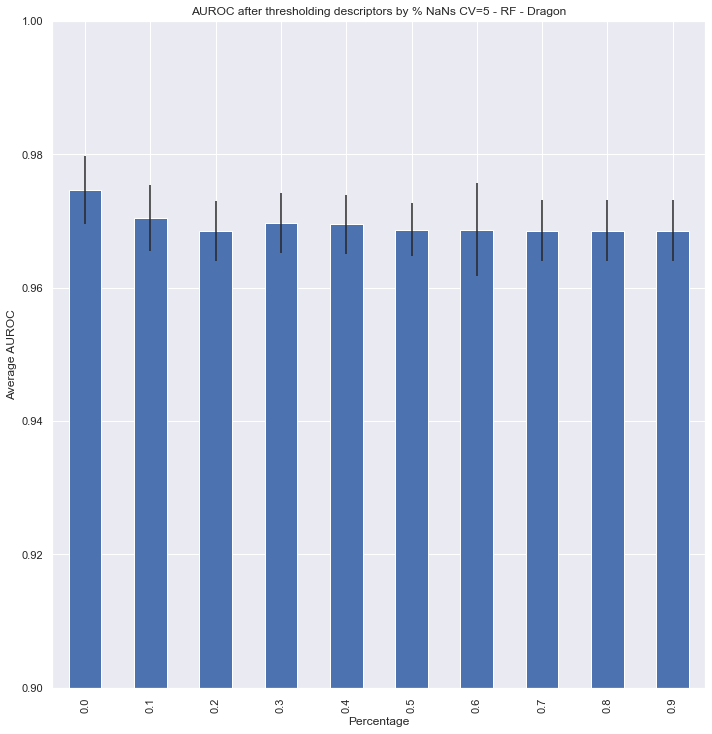

In [160]:
# choose optimal threshold for removing columns with NaNs
optimiseNaNs(clf, X_train_rf, X_test_rf, y_train_rf, y_test_rf, option=3)

In [200]:
# Handle NaNs in random forest
X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=1)
X_train_t_rf, X_val_rf = handleNaNs(X_train_t.copy(), X_val.copy(), option=1)

In [162]:
clf.fit(X_train_rf, y_train_rf)
print("Cross validated = 5 performance of Random Forest after removing all columns with NaNs")
test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)

Cross validated = 5 performance of Random Forest after removing all columns with NaNs
AVERAGE CV=5 ROC_AUC: 0.9746508451865594
AVERAGE CV=5 STD: 0.005104787089696051


(0.9746508451865594, 0.005104787089696051)

## Using PCA to reduce dimensionality

Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.6153883219954649
AVERAGE CV=5 STD: 0.042032353336206175
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.8503161719233148
AVERAGE CV=5 STD: 0.01987409178504437
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.9575899299113585
AVERAGE CV=5 STD: 0.013243105492361925
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.9620449391877963
AVERAGE CV=5 STD: 0.016958412291537186
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.9649543908472479
AVERAGE CV=5 STD: 0.017558204935584257
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.9649345495774065
AVERAGE CV=5 STD: 0.012788298905178096
Validation performance of Random Forest after r

(0.0, 1.0)

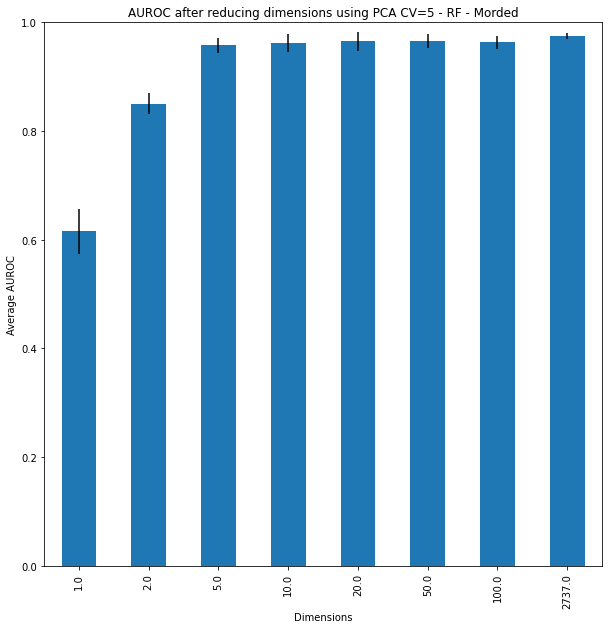

In [25]:
from sklearn import decomposition 

pca_df = pd.DataFrame(columns=['Dimensions', 'Average AUROC', 'Standard Deviation'])

roc_aucs = []
stds = []
pcas = [1, 2, 5, 10, 20, 50, 100]

for n in pcas:
    pca = decomposition.PCA(n_components=n)
    pca_result = pca.fit_transform(X_train_rf)
    clf.fit(pca_result, y_train_rf)
    
    print("Validation performance of Random Forest after reducing dimensionality with PCA")
    roc_auc, std = test_model_cross_val(clf, y_train_rf, pca_result, k=5, verbose=True)
    
    pca_df = pca_df.append({'Dimensions': n, 
                           'Average AUROC':roc_auc, 
                           'Standard Deviation':std}, 
                            ignore_index = True)

clf.fit(X_train_rf, y_train_rf)
print("Validation performance of Random Forest with all dimensions")
roc_auc, std = test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)
roc_aucs.append(roc_auc)
pca_df = pca_df.append({'Dimensions': X_train_rf.shape[-1], 
                       'Average AUROC':roc_auc, 
                       'Standard Deviation':std}, 
                        ignore_index = True)

fig = pca_df.plot(kind="bar", x="Dimensions", y="Average AUROC", ylabel="Average AUROC", 
                   yerr="Standard Deviation", title=f"AUROC after reducing dimensions using PCA CV=5 - RF - {dataset}", 
                   legend=False, figsize=(10, 10))

plt.ylim(0,1)
        

(0.0, 1.0)

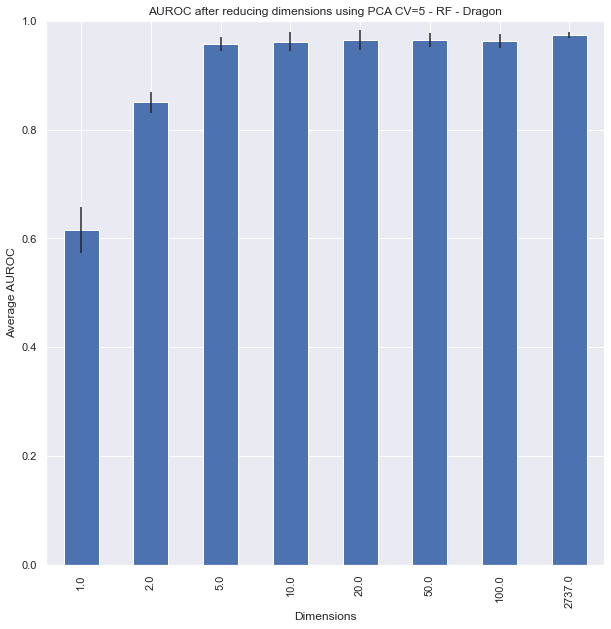

In [144]:
fig = pca_df.plot(kind="bar", x="Dimensions", y="Average AUROC", ylabel="Average AUROC", 
                   yerr="Standard Deviation", title=f"AUROC after reducing dimensions using PCA CV=5 - RF - {dataset}", 
                   legend=False, figsize=(10, 10))

plt.ylim(0,1)

## Importance experiment

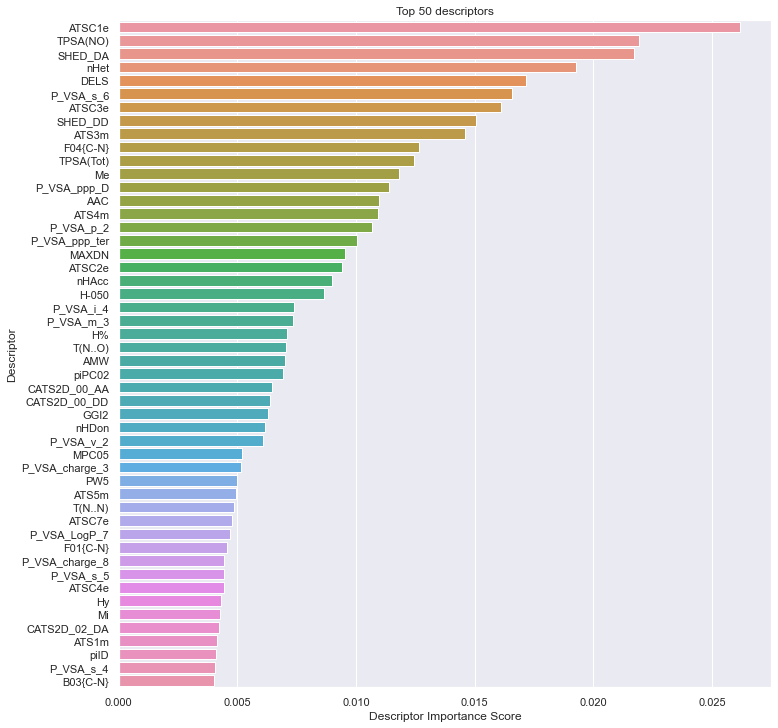

Cross validated importance experiment with k=5


,Most important N descriptors,Average AUROC,Standard Deviation
0,1.0,0.839253,0.032477
1,2.0,0.925894,0.022807
2,5.0,0.952120,0.014115
3,10.0,0.964418,0.008325
4,25.0,0.963490,0.009128
5,50.0,0.972784,0.006899
6,100.0,0.974371,0.005641
7,200.0,0.973643,0.006646
8,400.0,0.974944,0.003783
9,2737.0,0.975713,0.002624


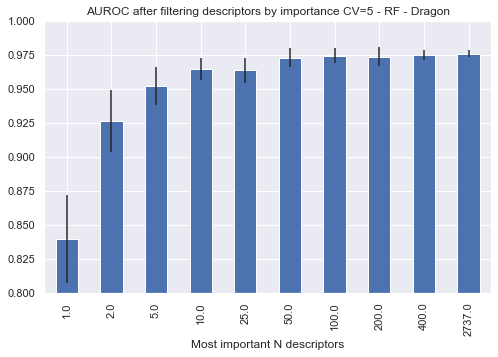

In [26]:
clf.fit(X_train_rf, y_train_rf)
optimiseImportance(clf, X_train_rf, y_train_rf)

AVERAGE CV=5 ROC_AUC: 0.9746508451865594
AVERAGE CV=5 STD: 0.005104787089696051


,Most important N descriptors,Average AUROC,Standard Deviation
0,0.0,0.974651,0.005105
1,5.0,0.974620,0.006867
2,10.0,0.974514,0.005195
3,25.0,0.974636,0.004194
4,50.0,0.976575,0.003665
5,100.0,0.974863,0.007494
6,200.0,0.973822,0.007388
7,400.0,0.964558,0.007349


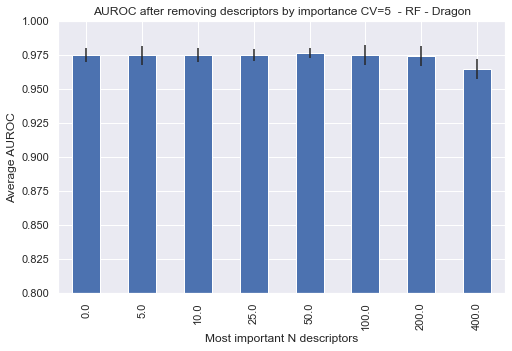

In [27]:
clf.fit(X_train_rf, y_train_rf)
testWithoutImportantDescs(clf, X_train_rf, y_train_rf)

In [201]:
# Filter labels by importance
clf.fit(X_train_rf, y_train_rf)
X_train_rf, X_test_rf, clf = handle_importance(clf, 
                                               X_train_rf, 
                                               X_test_rf, 
                                               threshold=-1, 
                                               n=400)

In [48]:
clf.fit(X_train_rf, y_train_rf)
print("Cross validated training set performance of Random Forest after removing labels")
test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)

Cross validated training set performance of Random Forest after removing labels
AVERAGE CV=5 ROC_AUC: 0.9749435683364254
AVERAGE CV=5 STD: 0.0037829955537701746


(0.9749435683364254, 0.0037829955537701746)

In [164]:
X_train_rf

,ATSC1e,TPSA(NO),SHED_DA,nHet,DELS,P_VSA_s_6,ATSC3e,SHED_DD,ATS3m,F04{C-N},...,MATS3p,ATS6e,GATS6v,SpMax7_Bh(m),P_VSA_charge_1,C-005,IC5,ATSC5v,ATS4p,P_VSA_MR_1
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.171284,0.527110,0.353553,0.357143,0.222086,0.437042,0.238702,0.0,0.664266,0.0625,...,0.364938,0.417508,0.134525,0.402475,0.166667,0.0,0.631044,0.036715,0.521053,0.121212
CCCCCCCCCCCCCCCCO,0.057707,0.128290,0.000000,0.071429,0.053906,0.157321,0.088196,0.0,0.671234,0.0000,...,0.523817,0.863838,0.253892,0.803813,0.166667,0.0,0.675486,0.401123,0.803934,0.939394
C1(C(O1)(F)F)(C(F)(F)F)F,0.424925,0.079460,0.000000,0.500000,0.365831,0.371381,0.227703,0.0,0.733956,0.0000,...,0.441495,0.000000,0.000000,0.444882,0.000000,0.0,0.177719,0.000000,0.101427,0.000000
CC(C)(C=C)O,0.024292,0.128290,0.000000,0.071429,0.057016,0.215435,0.080955,0.0,0.421047,0.0000,...,0.329584,0.000000,0.000000,0.025124,0.166667,0.0,0.208406,0.030983,0.462788,0.090909
C=CCC1=CC2=C(C=C1)OCO2,0.005752,0.117065,0.000000,0.142857,0.075883,0.139200,0.044040,0.0,0.642687,0.0000,...,0.444554,0.598595,0.262262,0.488339,0.085903,0.0,0.755022,0.135926,0.626895,0.303030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.015490,0.000000,0.000000,0.071429,0.017368,0.142137,0.018355,0.0,0.398430,0.0000,...,0.533509,0.241235,0.000000,0.025124,0.000000,0.0,0.364451,0.038821,0.442324,0.239972
CCN(CC)CC,0.030893,0.020547,0.000000,0.071429,0.017297,0.000000,0.047670,0.0,0.485766,0.0000,...,0.621951,0.597977,0.000000,0.176263,0.012200,0.0,0.258013,0.127929,0.607383,0.181818
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.009173,0.108250,0.000000,0.071429,0.089415,0.092679,0.030155,0.0,0.686720,0.0000,...,0.468224,0.644251,0.314060,0.676243,0.000000,0.0,0.541308,0.121204,0.655778,0.303030
N,0.000000,0.301731,0.000000,0.142857,0.000000,0.228053,0.000000,0.0,0.000000,0.0000,...,0.524999,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


## Tuning the hyperparamaters 

In [50]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [51]:
params = {
    'n_estimators': (10, 2000),
    'min_samples_split': (1, 100),
    'max_depth': (3,200),
    'min_samples_leaf': (1, 10)
    }

def rf_hyper_param(n_estimators, 
                       min_samples_split, 
                       max_depth, 
                       min_samples_leaf):

    max_depth = int(max_depth)
    min_samples_leaf = int(min_samples_leaf)
    min_samples_split = int(min_samples_split)
    n_estimators = int(n_estimators)

    rf_temp = RandomForestClassifier(
        n_estimators=n_estimators, 
        min_samples_split=min_samples_split, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf)
    
    # calculate CV=3 K fold ROC_AUC accuracy for each model 

    return np.array(cross_val_score(rf_temp, X_train_rf, y_train_rf, cv=3, scoring='roc_auc')).mean()

optimizer = BayesianOptimization(
            f=rf_hyper_param,
            pbounds=params,
            random_state=SEED)

optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9646    | 111.1     | 7.437     | 60.67     | 1.094e+03 |
| 2         | 0.9664    | 86.46     | 6.813     | 44.32     | 1.785e+03 |
| 3         | 0.9659    | 192.8     | 4.451     | 79.38     | 1.063e+03 |
| 4         | 0.967     | 114.9     | 9.33      | 8.033     | 183.4     |
| 5         | 0.9635    | 6.983     | 8.494     | 78.04     | 1.741e+03 |
| 6         | 0.9658    | 91.75     | 7.272     | 45.62     | 1.788e+03 |
| 7         | 0.9689    | 123.7     | 4.446     | 23.08     | 177.3     |
| 8         | 0.9639    | 124.1     | 8.708     | 83.73     | 1.245e+03 |
| 9         | 0.9689    | 120.6     | 2.971     | 29.27     | 176.8     |
| 10        | 0.9662    | 150.3     | 7.599     | 29.05     | 160.4     |
| 11        | 0.9671    | 137.2     | 6.542     | 28.95     | 204.1     |
| 12        | 0.9694    | 110.8     | 

In [52]:
params_tuned_rf = optimizer.max['params']
params_tuned_rf['max_depth'] = int(params_tuned_rf['max_depth'])
params_tuned_rf['n_estimators'] = int(params_tuned_rf['n_estimators'])
params_tuned_rf['min_samples_leaf'] = int(params_tuned_rf['min_samples_leaf'])
params_tuned_rf['min_samples_split'] = int(params_tuned_rf['min_samples_split'])

tuned_rf = RandomForestClassifier(**params_tuned_rf, random_state=SEED)
test_model_cross_val(tuned_rf, y_train_rf, X_train_rf, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC: 0.9749190888476603
AVERAGE CV=5 STD: 0.004948662534486416


(0.9749190888476603, 0.004948662534486416)

In [53]:
print(params_tuned_rf)

{'max_depth': 139, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 109}


In [205]:
# Run me if you want the tuned model without running training

clf=RandomForestClassifier(random_state=SEED) 

# For readability
y_train_rf = y_train.copy()
y_test_rf = y_test.copy()
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

# Handle NaNs
X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=1)
X_train_t_rf, X_val_rf = handleNaNs(X_train_t.copy(), X_val.copy(), option=1)

# Fit model 
clf.fit(X_train_rf, y_train_rf)

# Handle features 
X_train_rf, X_test_rf, clf = handle_importance(clf, 
                                               X_train_rf, 
                                               X_test_rf, 
                                               threshold=-1, 
                                               n=400)

# Create tuned model
params_tuned_rf_saved = {'max_depth': 139, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 109}
tuned_rf = RandomForestClassifier(**params_tuned_rf_saved, random_state=SEED)
tuned_rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=139, n_estimators=109, random_state=0)

ROC_AUC (TEST): 0.9796747967479674


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False     0.8654    0.9000    0.8824        50
        True     0.9587    0.9431    0.9508       123

    accuracy                         0.9306       173
   macro avg     0.9120    0.9215    0.9166       173
weighted avg     0.9317    0.9306    0.9310       173



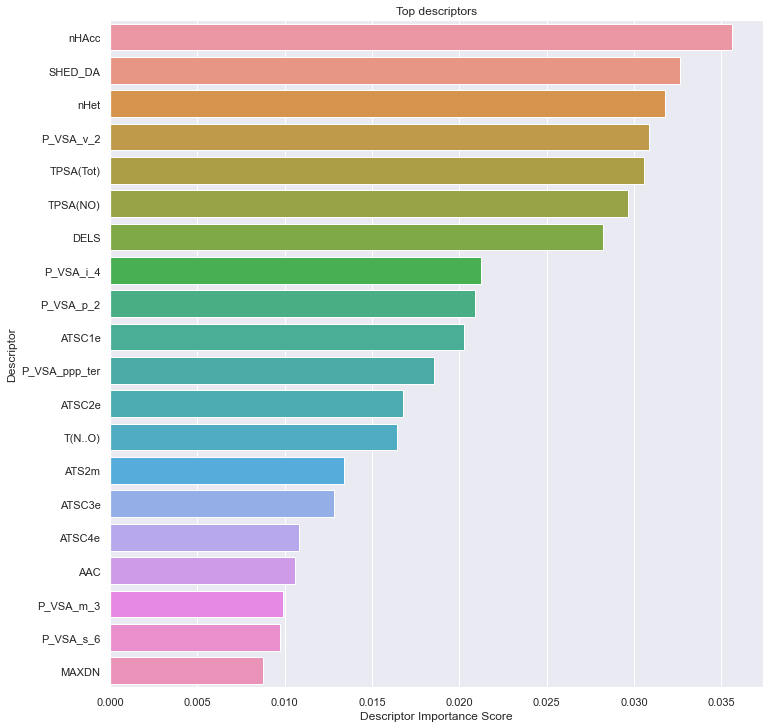

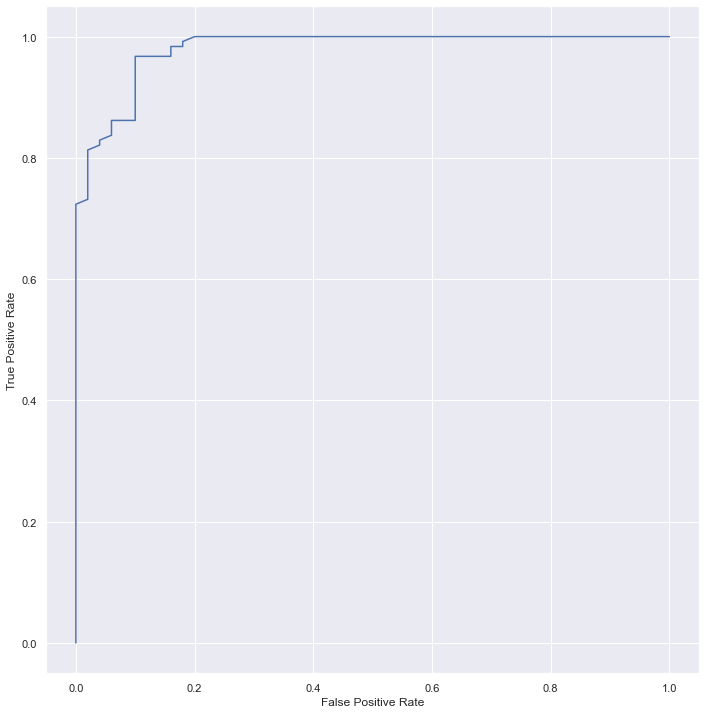

0.9796747967479674

In [206]:
tuned_rf.fit(X_train_rf, y_train_rf)
test_model(tuned_rf, y_test_rf, X_test_rf)

## Extract correlation scores for important features

Extracted correlation scores for most important 100 features for random forest
Printing heatmap for most important 15 features


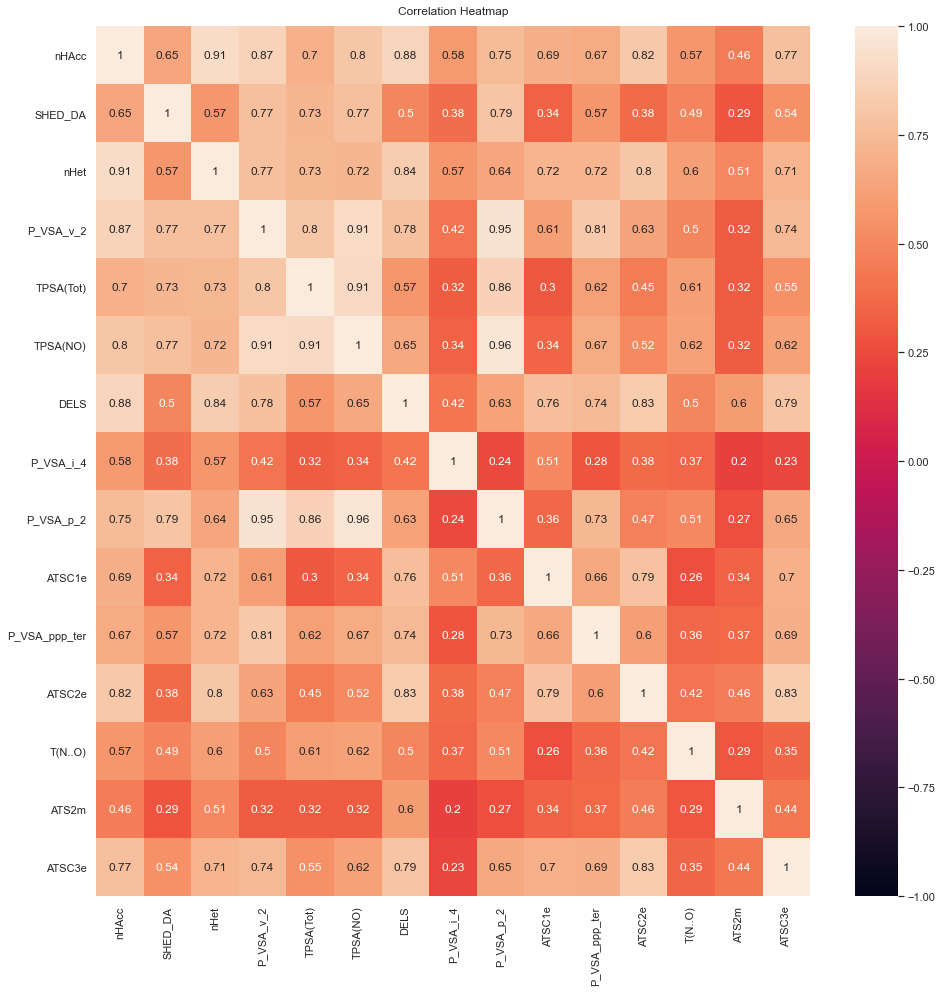

In [56]:
corrs_important_features(tuned_rf, X_test_rf, "random forest", 100, heatmap=2)

## Save dataframe used in RF to CSV
- i.e. dataframe with all columns with *any* missing values removed

In [57]:
rf_csv = df.loc[:,X_train_rf.columns]
rf_csv.to_csv('data/random-forest-df.csv')  
rf_csv

,ATSC1e,TPSA(NO),SHED_DA,nHet,DELS,P_VSA_s_6,ATSC3e,SHED_DD,ATS3m,F04{C-N},...,MATS3p,ATS6e,GATS6v,SpMax7_Bh(m),P_VSA_charge_1,C-005,IC5,ATSC5v,ATS4p,P_VSA_MR_1
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,0.163626,74.60,1.649385,4,29.268889,135.656540,0.641793,1.0,3.460840,0,...,-0.150463,2.760988,1.116492,1.970969,85.366686,0,3.300559,1.276023,2.750173,47.084408
C(=C(F)F)(C(F)(F)F)C(F)(F)F,0.642663,0.00,0.000000,8,51.030093,119.680906,0.734472,0.0,3.270025,0,...,-1.000000,0.000000,0.000000,1.581000,0.000000,0,0.000000,0.000000,1.139843,0.000000
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],0.264780,157.69,3.571652,10,46.596296,194.924085,0.626771,0.0,3.516157,3,...,-0.502081,3.458108,0.459471,1.645611,42.683343,0,3.300559,0.690297,2.684819,23.542204
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,0.010644,32.67,0.000000,4,16.991718,81.079101,0.215956,0.0,3.849487,7,...,-0.042869,4.366540,0.991584,2.686650,3.124314,1,4.597276,9.250521,3.799610,153.024326
C(C(C(F)(F)F)(F)Cl)(F)Cl,0.465056,0.00,0.000000,7,34.349537,153.097854,0.537891,0.0,3.966823,0,...,-0.224370,0.000000,0.000000,1.581000,0.000000,0,0.000000,0.000000,1.047157,11.771102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,0.012223,26.30,0.000000,2,9.679019,36.144815,0.184200,0.0,2.399314,0,...,0.111711,3.326703,0.953290,1.358132,10.999888,0,3.762267,3.162021,2.578761,129.482122
C=CCSS(=O)CC=C,0.037711,17.07,0.000000,3,9.490336,53.690316,0.091026,0.0,2.870537,0,...,-0.101569,2.915934,1.045377,1.049575,0.000000,0,3.826875,2.700325,2.651086,117.711020
CCCC(=O)OCC(C)C,0.019560,26.30,0.000000,2,10.368409,36.144815,0.152047,0.0,2.599054,0,...,-0.219914,3.519710,1.400573,1.466603,10.999888,0,3.613337,3.319666,2.734278,176.566530
CCCCCOC(=O)CCC,0.026034,26.30,0.000000,2,10.724677,36.144815,0.179834,0.0,2.642570,0,...,0.016506,3.666695,0.994636,1.793477,10.999888,0,4.116265,4.392550,2.887784,188.337632


# XgBoost

https://practicaldatascience.co.uk/machine-learning/how-to-create-a-classification-model-using-xgboost

In [171]:
# for readibility 
y_train_xgb = y_train.copy()
y_test_xgb = y_test.copy()
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

## Create model

In [172]:
xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [173]:
# Baseline results
print("Baseline performance of XGBoost")
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Baseline performance of XGBoost
AVERAGE CV=5 ROC_AUC: 0.9695603999175427
AVERAGE CV=5 STD: 0.0033966784988894204


(0.9695603999175427, 0.0033966784988894204)

## Handle NaNs

Cross validated missing values experiment with k=5


,Percentage,Average AUROC,Standard Deviation
0,0.0,0.970966,0.005928
1,0.1,0.971088,0.002895
2,0.2,0.970019,0.002457
3,0.3,0.969209,0.002121
4,0.4,0.969362,0.001966
5,0.5,0.966764,0.004098
6,0.6,0.969560,0.003397
7,0.7,0.969560,0.003397
8,0.8,0.969560,0.003397
9,0.9,0.969560,0.003397


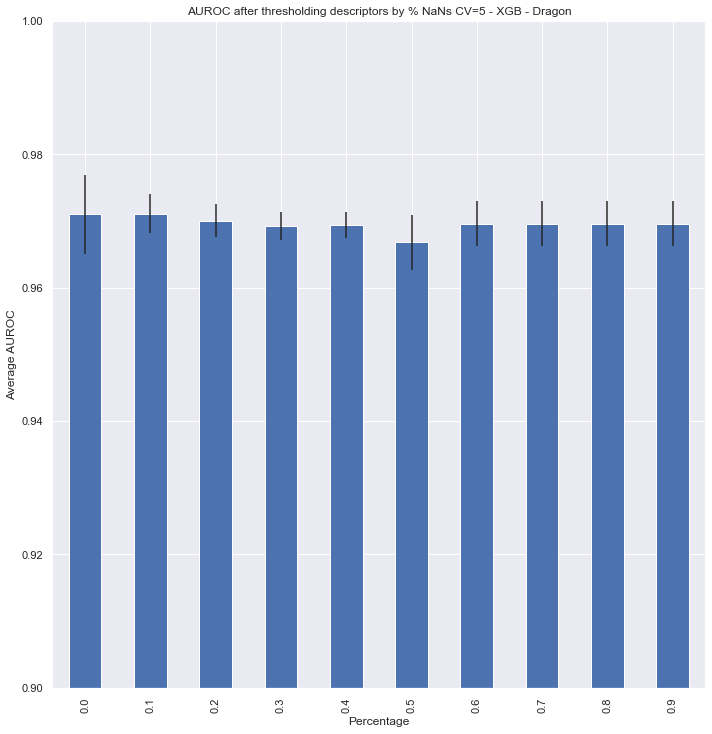

In [151]:
# choose optimal threshold for removing columns with NaNs
# RETAIN MISSING VALUES UNDER THRESHOLD 
optimiseNaNs(xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, option=2, model_name="XGB")

Cross validated missing values experiment with k=5


,Percentage,Average AUROC,Standard Deviation
0,0.0,0.970966,0.005928
1,0.1,0.970070,0.004616
2,0.2,0.968938,0.003874
3,0.3,0.970517,0.003590
4,0.4,0.969653,0.003650
5,0.5,0.970164,0.002947
6,0.6,0.970061,0.002891
7,0.7,0.970010,0.002909
8,0.8,0.970010,0.002909
9,0.9,0.970010,0.002909


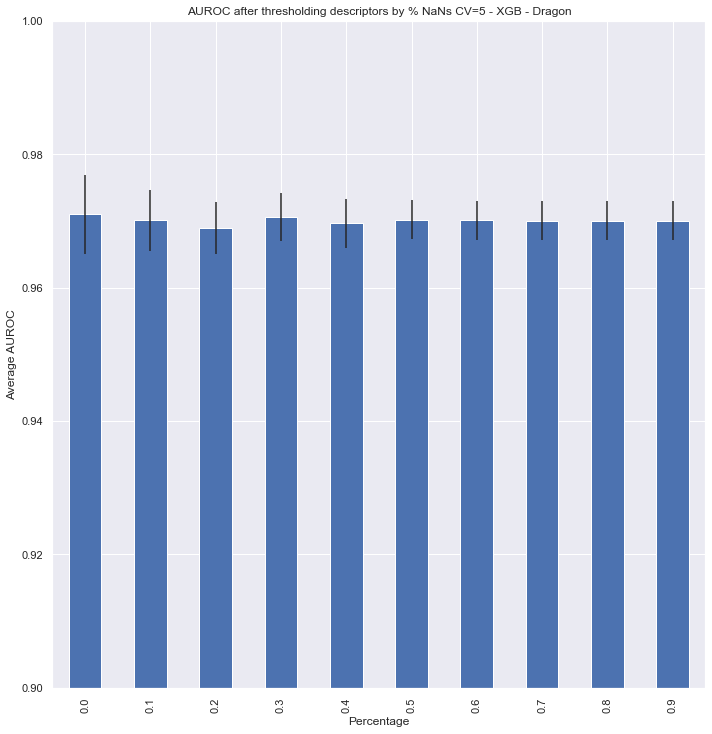

In [152]:
# REMOVE IMPUTING MISSING VALUES UNDER THRESHOLD 
optimiseNaNs(xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, option=3, model_name="XGB")

In [174]:
X_train_xgb, X_test_xgb = handleNaNs(X_train.copy(), X_test.copy(), option=2, thresh=0.1)
X_train_t_xgb, X_val_xgb = handleNaNs(X_train_t.copy(), X_val.copy(), option=2, thresh=0.1)

In [175]:
xgb.fit(X_train_xgb, y_train_xgb)
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC: 0.9710884353741497
AVERAGE CV=5 STD: 0.0028953080362300976


(0.9710884353741497, 0.0028953080362300976)

## Importance Experiment XGB

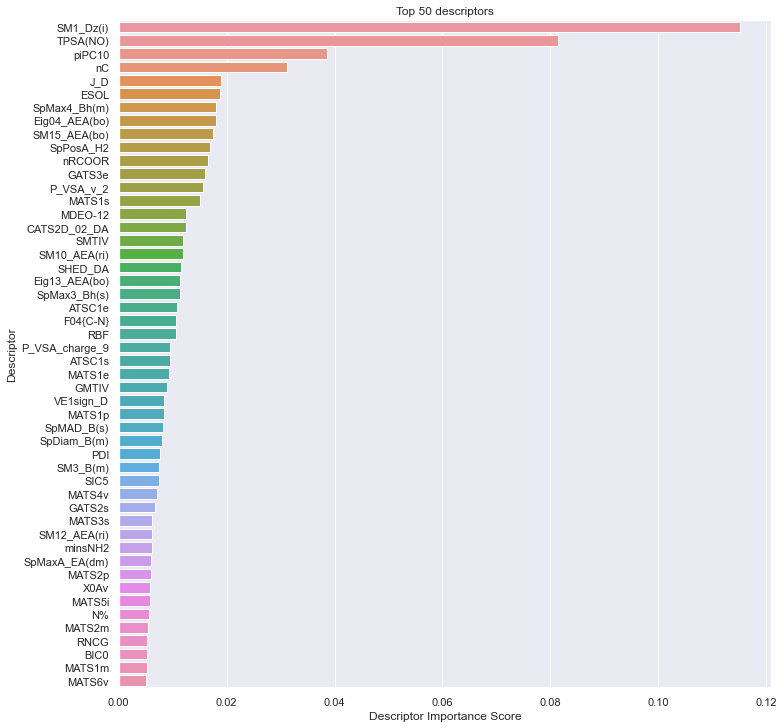

Cross validated importance experiment with k=5


,Most important N descriptors,Average AUROC,Standard Deviation
0,1.0,0.913905,0.022212
1,2.0,0.934173,0.016917
2,5.0,0.953642,0.016088
3,10.0,0.959928,0.006803
4,25.0,0.966440,0.004893
5,50.0,0.967470,0.004633
6,100.0,0.972350,0.004061
7,200.0,0.973116,0.001414
8,400.0,0.973219,0.003705
9,3263.0,0.969560,0.003050


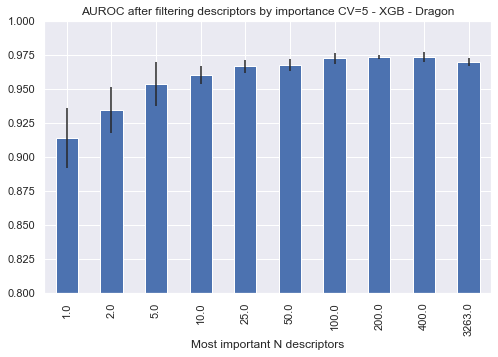

In [154]:
xgb.fit(X_train_xgb, y_train_xgb)
optimiseImportance(xgb, X_train_xgb, y_train_xgb, model_name="XGB")

AVERAGE CV=5 ROC_AUC: 0.9710884353741497
AVERAGE CV=5 STD: 0.0028953080362300976


,Most important N descriptors,Average AUROC,Standard Deviation
0,0.0,0.971088,0.002895
1,5.0,0.970778,0.003354
2,10.0,0.969058,0.004837
3,25.0,0.969906,0.004341
4,50.0,0.971937,0.005071
5,100.0,0.968833,0.004906
6,200.0,0.959006,0.009209
7,400.0,0.960188,0.006913


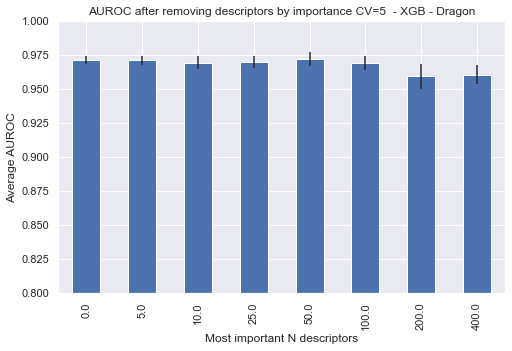

In [155]:
xgb.fit(X_train_xgb, y_train_xgb)
testWithoutImportantDescs(xgb, X_train_xgb, y_train_xgb, model_name="XGB")

In [176]:
X_train_xgb, X_test_xgb, xgb = handle_importance(xgb, 
                                                X_train_xgb, 
                                                X_test=X_test_xgb, 
                                                threshold=-1, 
                                                n=400)

X_train_t_xgb, X_val_xgb, xgb = handle_importance(xgb, 
                                                X_train_t_xgb, 
                                                X_test=X_val_xgb, 
                                                threshold=-1, 
                                                n=400)
xgb.fit(X_train_t_xgb, y_train_t)

# Filted importance results
print("Cross validated CV=5 performance after filtering by importance XGBoost")
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Cross validated CV=5 performance after filtering by importance XGBoost
AVERAGE CV=5 ROC_AUC: 0.9723500309214594
AVERAGE CV=5 STD: 0.004060599302712191


(0.9723500309214594, 0.004060599302712191)

In [177]:
X_train_xgb

,SM1_Dz(i),TPSA(NO),piPC10,nC,J_D,ESOL,SpMax4_Bh(m),Eig04_AEA(bo),SM15_AEA(bo),SpPosA_H2,...,Hy,SpMax_B(p),J_Dt,P_VSA_MR_5,GATS1m,SpMin1_Bh(s),ATSC2s,P_VSA_e_2,MDEC-11,GATS4s
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.471852,0.527110,0.000000,0.269231,0.254811,0.554607,0.721274,0.718805,0.238356,0.575699,...,0.110161,0.782638,0.206155,0.000000,0.239268,0.641131,0.210110,0.276802,0.000000,0.357807
CCCCCCCCCCCCCCCCO,0.242697,0.128290,0.202413,0.615385,0.363241,0.311740,0.886242,0.685907,0.607171,0.617089,...,0.062449,0.524119,0.444478,0.361255,0.585782,0.857190,0.029053,0.274028,0.000000,0.160562
C1(C(O1)(F)F)(C(F)(F)F)F,0.724321,0.079460,0.000000,0.115385,0.349888,0.541786,0.424445,0.277327,0.238356,0.317415,...,0.078188,0.737551,0.324200,0.094915,0.596178,0.255270,0.412359,0.071997,0.000000,0.000000
CC(C)(C=C)O,0.242697,0.128290,0.000000,0.192308,0.426637,0.681688,0.575733,0.136921,0.476712,0.191947,...,0.110899,0.633226,0.499786,0.143907,0.507938,0.616666,0.034695,0.265276,0.254136,0.174812
C=CCC1=CC2=C(C=C1)OCO2,0.306878,0.117065,0.345379,0.384615,0.164799,0.498267,0.734206,0.727926,0.400650,0.727583,...,0.020126,0.781682,0.081740,0.074885,0.302553,0.690341,0.040612,0.473296,0.000000,0.216112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.129394,0.000000,0.000000,0.153846,0.234245,0.615808,0.474306,0.000000,0.476712,0.412702,...,0.125213,0.490999,0.331939,0.120617,0.457752,0.733101,0.010097,0.329991,0.000000,0.233583
CCN(CC)CC,0.262960,0.020547,0.000000,0.230769,0.391973,0.653636,0.609328,0.266697,0.476712,0.472569,...,0.020711,0.505712,0.469545,0.292837,0.597729,0.703754,0.015955,0.202807,0.166506,0.289350
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.242697,0.108250,0.557940,0.500000,0.160932,0.384177,0.721274,0.752981,0.636145,0.791306,...,0.009214,0.792139,0.124274,0.000000,0.297718,0.668962,0.014079,0.657211,0.000000,0.503801
N,0.341642,0.301731,0.000000,0.000000,0.000000,0.850630,0.000000,0.136921,0.476712,0.084819,...,0.110400,0.331207,0.127579,0.504466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Tuning paramaters 

In [223]:
params = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
#    'subsample': (0.7, 1.0),  # Change for big datasets
    'colsample_bytree': (0.7, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5), 
    'reg_lambda': (0, 2),
    'reg_alpha':(0, 2),
    'scale_pos_weight': (1, 2.5)
    }

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        colsample_bytree,
                        gamma, 
                        reg_lambda, 
                        reg_alpha,
                        scale_pos_weight):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    xgb_temp = XGBClassifier(
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        reg_lambda=reg_lambda, 
        reg_alpha=reg_alpha,
        scale_pos_weight=scale_pos_weight,
        seed=SEED)
    
    # calculate CV=3 K fold ROC_AUC accuracy for each model 

    return np.array(cross_val_score(xgb_temp, X_train_xgb, y_train_xgb, cv=3, scoring='roc_auc')).mean()

optimizer = BayesianOptimization(
            f=xgboost_hyper_param,
            pbounds=params,
            random_state=SEED)

optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | scale_... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9604    | 0.8646    | 3.576     | 0.6067    | 6.814     | 481.3     | 1.292     | 0.8752    | 2.338     |
| 2         | 0.9635    | 0.9891    | 1.917     | 0.7938    | 6.702     | 611.2     | 1.851     | 0.1421    | 1.131     |
| 3         | 0.9618    | 0.7061    | 4.163     | 0.7804    | 9.09      | 980.8     | 1.598     | 0.923     | 2.171     |
| 4         | 0.9707    | 0.7355    | 3.2       | 0.1519    | 9.613     | 569.7     | 0.8293    | 0.5291    | 2.161     |
| 5         | 0.9701    | 0.8368    | 2.842     | 0.0286    | 7.323     | 650.9     | 1.234     | 1.887     | 2.023     |
| 6         | 0.9694    | 0.9245    | 4.506     | 0.1645    | 9.11      | 569.6     | 0.5934    | 0.02827   | 2.255     |
| 7         | 0.9678    

| 41        | 0.972     | 0.7325    | 2.823     | 0.1879    | 8.759     | 642.4     | 0.1907    | 0.4139    | 2.189     |
| 42        | 0.9671    | 0.9863    | 0.244     | 0.7147    | 9.665     | 643.1     | 0.649     | 1.471     | 1.205     |
| 43        | 0.9671    | 0.8163    | 0.14      | 0.8292    | 6.16      | 560.5     | 1.832     | 0.9112    | 2.337     |
| 44        | 0.9695    | 0.9589    | 2.8       | 0.4872    | 7.285     | 640.4     | 0.0546    | 1.697     | 2.103     |
| 45        | 0.9715    | 0.9038    | 1.854     | 0.2474    | 6.319     | 641.1     | 0.1959    | 0.04818   | 2.199     |
| 46        | 0.9598    | 0.9632    | 2.868     | 0.7347    | 3.656     | 561.7     | 0.08509   | 1.554     | 1.006     |
| 47        | 0.9731    | 0.9046    | 0.08247   | 0.1825    | 7.916     | 643.6     | 0.5122    | 0.1227    | 2.383     |
| 48        | 0.9706    | 1.0       | 0.0       | 0.01      | 3.0       | 664.3     | 1.508     | 2.0       | 1.789     |
| 49        | 0.9678    

In [224]:
params_tuned_xgb = optimizer.max['params']
params_tuned_xgb['max_depth'] = int(params_tuned_xgb['max_depth'])
params_tuned_xgb['n_estimators'] = int(params_tuned_xgb['n_estimators'])
print(params_tuned_xgb)

tuned_xgb = XGBClassifier(**params_tuned_xgb, seed=SEED)
test_model_cross_val(tuned_xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 564, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'scale_pos_weight': 2.5}
AVERAGE CV=5 ROC_AUC: 0.9733163265306125
AVERAGE CV=5 STD: 0.0022444317700125917


(0.9733163265306125, 0.0022444317700125917)

In [225]:
params = {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 564, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'scale_pos_weight': 2.5}
tuned_xgb = XGBClassifier(**params,
                       seed=SEED,  
                       n_jobs = -1)

### Final tuned paramaters


In [226]:
# Run me if you want the tuned model without running training

# for readibility 
y_train_xgb = y_train.copy()
y_test_xgb = y_test.copy()
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train_xgb, y_train_xgb)

# Handle NaNs
X_train_xgb, X_test_xgb = handleNaNs(X_train.copy(), X_test.copy(), option=2, thresh=0.1)
X_train_t_xgb, X_val_xgb = handleNaNs(X_train_t.copy(), X_val.copy(), option=2, thresh=0.1)

# Fit model 
xgb.fit(X_train_xgb, y_train_xgb)

# Handle features 
X_train_xgb, X_test_xgb, xgb = handle_importance(xgb, 
                                                X_train_xgb, 
                                                X_test=X_test_xgb, 
                                                threshold=-1, 
                                                n=400)

X_train_t_xgb, X_val_xgb, xgb = handle_importance(xgb, 
                                                X_train_t_xgb, 
                                                X_test=X_val_xgb, 
                                                threshold=-1, 
                                                n=400)
xgb.fit(X_train_xgb, y_train_xgb)

# Create tuned model
params_tuned_xgb_saved = {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 564, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'scale_pos_weight': 2.5}
tuned_xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=564, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [227]:
print("Final tuned CV performance for XGB")
tuned_xgb.fit(X_train_xgb, y_train)
test_model_cross_val(tuned_xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Final tuned CV performance for XGB
AVERAGE CV=5 ROC_AUC: 0.9733163265306125
AVERAGE CV=5 STD: 0.0022444317700125917


(0.9733163265306125, 0.0022444317700125917)

ROC_AUC (TEST): 0.9783739837398373


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False     0.9362    0.8800    0.9072        50
        True     0.9524    0.9756    0.9639       123

    accuracy                         0.9480       173
   macro avg     0.9443    0.9278    0.9355       173
weighted avg     0.9477    0.9480    0.9475       173



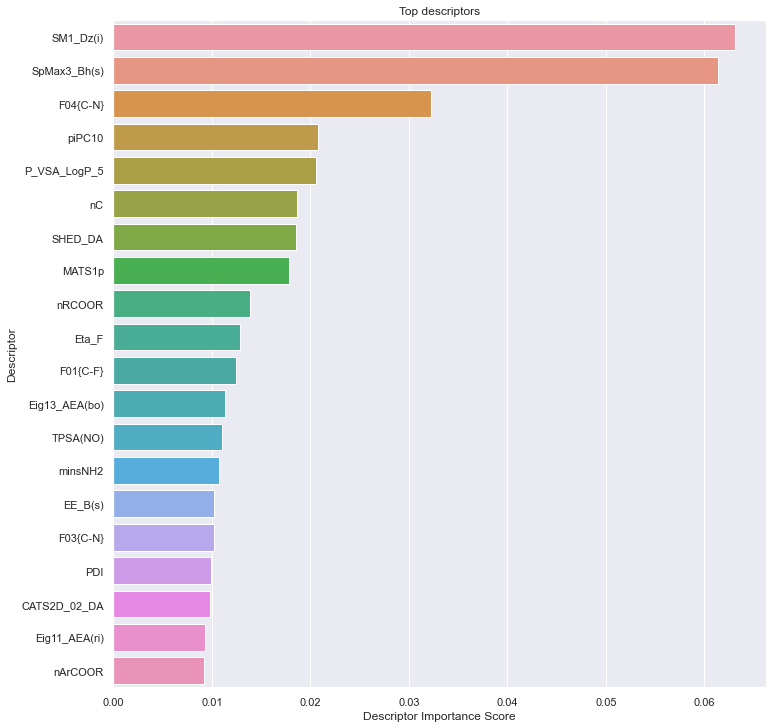

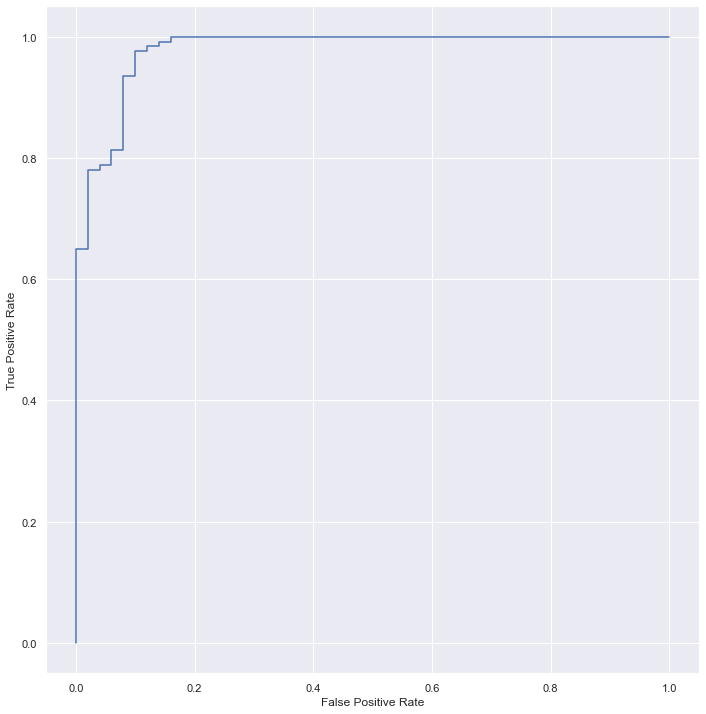

0.9783739837398373

In [228]:
tuned_xgb.fit(X_train_xgb, y_train_xgb)
test_model(tuned_xgb, y_test_xgb, X_test_xgb)

## Extract correlation for 'important' features

Extracted correlation scores for most important 100 features for xgb
Printing heatmap for most important 15 features


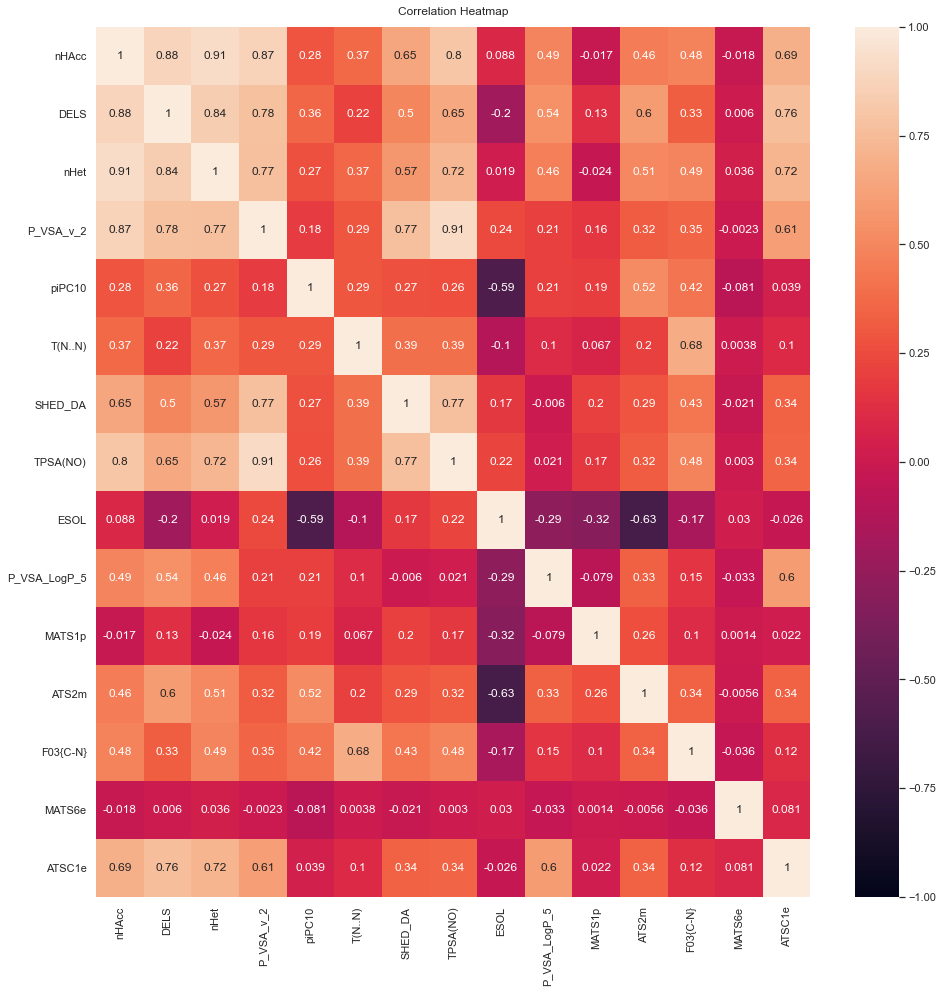

In [73]:
corrs_important_features(tuned_xgb, X_test_xgb, "xgb", 100, 15)

## Save dataframe used in XGB to CSV

In [74]:
rf_csv = df.loc[:,X_train_xgb.columns]
rf_csv.to_csv('data/xgb-df.csv')  
rf_csv

,nHAcc,piPC10,P_VSA_v_2,TPSA(NO),MDEC-12,ATS6m,T(N..N),DELS,nHet,MATS1p,...,B04{C-N},F02{C-O},AAC,Mi,P_VSA_charge_14,ATSC8i,SpMin1_Bh(p),GATS3p,HVcpx,MATS7p
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,4,4.123094,135.656540,74.60,0.000000,0.711439,0,29.268889,4,0.247893,...,0,8,1.509028,1.109642,0.000000,0.000000,1.958558,1.078185,2.213778,1.091589
C(=C(F)F)(C(F)(F)F)C(F)(F)F,8,0.000000,119.680906,0.00,0.000000,0.000000,0,51.030093,8,-0.181818,...,0,0,0.918296,1.364867,15.519032,0.000000,1.848830,2.062500,1.894368,0.000000
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],7,0.000000,211.934239,157.69,0.000000,3.273093,12,46.596296,10,0.462412,...,1,8,1.896820,1.155826,0.000000,0.000000,2.170518,1.602496,2.450122,0.762752
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,3,7.092158,45.054770,32.67,1.792087,3.653072,3,16.991718,4,-0.047977,...,1,1,1.586645,1.110339,0.000000,0.379352,2.031832,0.943105,2.737634,-0.312528
C(C(C(F)(F)F)(F)Cl)(F)Cl,5,0.000000,74.800566,0.00,0.000000,0.000000,0,34.349537,7,-0.068431,...,0,0,1.789929,1.295209,7.759516,0.000000,1.767601,1.206357,1.932857,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,2,0.000000,36.144815,26.30,2.809665,1.504045,0,9.679019,2,-0.236196,...,0,3,1.264673,1.144574,7.191330,0.102339,1.909060,0.760053,2.574065,-0.160612
C=CCSS(=O)CC=C,1,0.000000,22.156476,17.07,2.874433,1.409368,0,9.490336,3,0.167270,...,0,1,1.577977,1.111863,0.000000,0.079500,1.752398,1.274755,2.574065,0.176396
CCCC(=O)OCC(C)C,2,0.000000,36.144815,26.30,2.805348,1.829130,0,10.368409,2,-0.205085,...,0,3,1.238901,1.143862,7.191330,0.170973,1.918943,1.192712,2.596635,-0.011874
CCCCCOC(=O)CCC,2,0.000000,36.144815,26.30,3.346722,2.110566,0,10.724677,2,-0.181189,...,0,3,1.217016,1.143297,7.191330,0.240711,1.925612,0.891518,2.889022,-0.088467


# Compare descriptors used by both models 

In [75]:
len(set(X_train_rf.columns) - set(X_train_xgb.columns))

327

In [76]:
len(set(X_train_xgb.columns) - set(X_train_rf.columns))

27

# Keras

https://www.pluralsight.com/guides/classification-keras

In [242]:
!pip install keras
!pip install scikeras

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# for readibility 
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()
X_train_nn = X_train.copy()
X_test_nn = X_test.copy()
y_train_t_nn, y_val_nn = y_train_t.copy(), y_val.copy()

tf.random.set_seed(SEED)


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


## Preprocessing

### Handle NaNs 
- You can't have missing values in a Neural Network, so we choose to use the optimal value for XGB

In [243]:
X_train_nn, X_test_nn = handleNaNs(X_train.copy(), X_test.copy(), option=3, thresh=0.1)
X_train_t_nn, X_val_nn = handleNaNs(X_train_t.copy(), X_val.copy(), option=3, thresh=0.1)

### Encode class values as integers

In [245]:
encoder = LabelEncoder()
encoder.fit(y_train_t_nn)
y_train_nn = encoder.transform(y_train_nn)
y_train_t_nn = encoder.transform(y_train_t_nn)
y_test_nn = encoder.transform(y_test_nn)
y_val_nn = encoder.transform(y_val_nn)

## Early stopping

In [190]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
# Patience = 3 because we wait for 3 epochs without any improvement 
early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=15)

## Metrics

In [191]:
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc', curve='ROC'),
]

## Test model - Keras

In [238]:
def test_model_keras_train(model, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn): 
    # Plot training and validation auc 

    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('model roc_auc')
    plt.ylabel('ROC_AUC')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    # Plot training and validation ROC curve
    y_pred_keras = model.predict(X_val_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val_nn, y_pred_keras)
    auc_v_keras = metrics.roc_auc_score(y_val_nn, y_pred_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras)

    # Use the Keras model to make predictions on a test dataset
    y_pred_t_keras = model.predict(X_train_nn)
    
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_nn, y_pred_t_keras)
    auc_t_keras = metrics.roc_auc_score(y_train_nn, y_pred_t_keras)
    
    plt.plot(fpr_keras, tpr_keras)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(['', 'Validation (area = {:.4f})'.format(auc_v_keras), 'Training (area = {:.3f})'.format(auc_t_keras)], loc='best')
    plt.show()
    plt.show()
    
    # Print classification report 
    y_pred = model.predict(X_val_nn).round()
    print(metrics.classification_report(y_val_nn, y_pred, digits=4))


In [239]:
def test_model_keras(model, X_test_nn, y_test_nn, X_train_nn, y_train_nn):
    y_pred_t_keras = model.predict(X_test_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_nn, y_pred_t_keras)
    auc_t_keras = metrics.roc_auc_score(y_test_nn, y_pred_t_keras)
    auc_t_keras

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(['', 'Test (area = {:.4f})'.format(auc_t_keras)], loc='best')
    plt.show()
    plt.show()
    
    # Print classification report 
    y_pred = model.predict(X_test_nn).round()
    print(metrics.classification_report(y_test_nn, y_pred, digits=4))

## Baseline Single Layer model
- Overfitting quite a bit, you can see it when you compare the validation set auc and the auc for the training set 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3264)              10653696  
                                                                 
 dense_3 (Dense)             (None, 1)                 3265      
                                                                 
Total params: 10,656,961
Trainable params: 10,656,961
Non-trainable params: 0
_________________________________________________________________


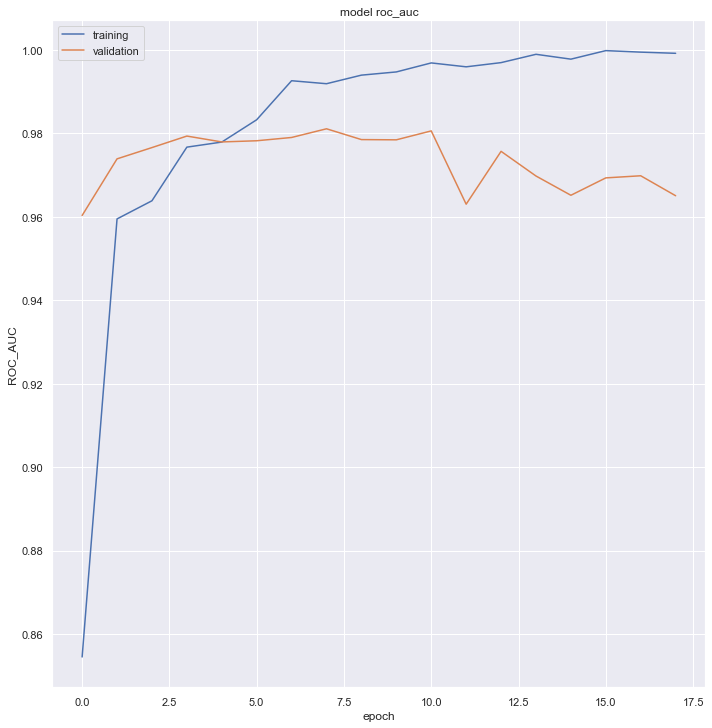

16/16 [==============================] - 0s 8ms/step


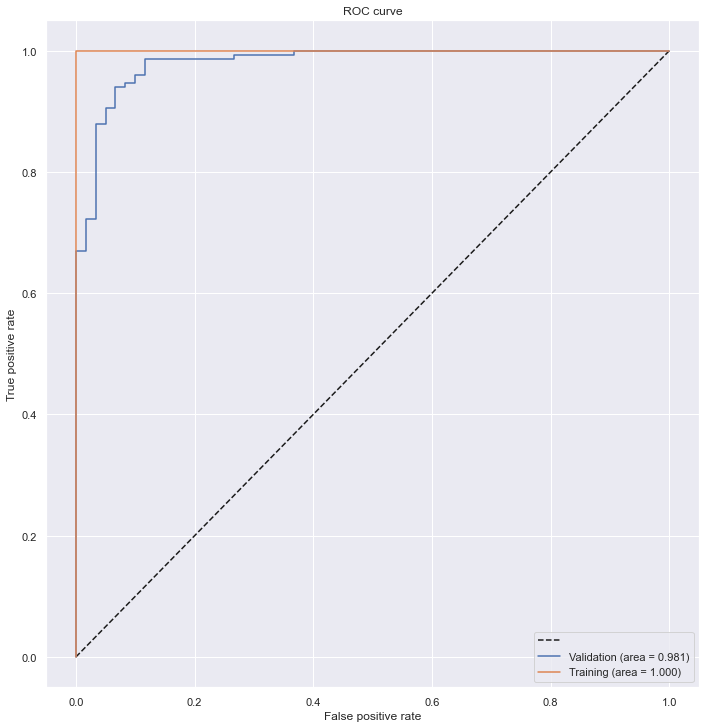

7/7 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        60
           1       0.94      0.99      0.96       148

    accuracy                           0.94       208
   macro avg       0.95      0.91      0.93       208
weighted avg       0.94      0.94      0.94       208



In [86]:
model = keras.Sequential()
model.add(keras.layers.Dense(X_train_nn.shape[-1]+1, activation="relu", input_shape=(X_train_nn.shape[-1],)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

history = model.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=100, 
                      validation_data=(X_val_nn, y_val_nn), 
                      callbacks=[early_stopping],
                      verbose=0)

test_model_keras_train(model, history, X_val_nn, y_val_nn, X_train_t_nn, y_train_t_nn)

6/6 [==============================] - 0s 8ms/step


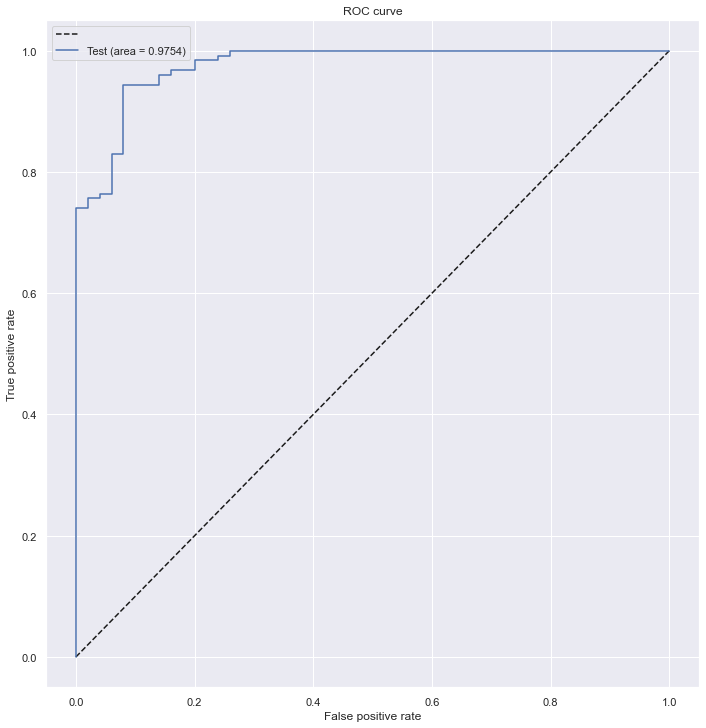

6/6 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0     0.9500    0.7600    0.8444        50
           1     0.9098    0.9837    0.9453       123

    accuracy                         0.9191       173
   macro avg     0.9299    0.8719    0.8949       173
weighted avg     0.9214    0.9191    0.9162       173



In [246]:
test_model_keras(model, X_test_nn, y_test_nn, X_train_t_nn, y_train_t_nn)

## Multi Layer Model

## Feature selection 

Using the set of the top 100 descriptors from RF and XGB, filter the dataset by these descriptors, and then measure validation accuracy

In [88]:
def model_builder_2(hp):

    model = keras.Sequential()
    model.add(Dense((X_train_t_nn_temp.shape[-1]), input_shape=((X_train_t_nn_temp.shape[-1]),), activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the second Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

### Use different algorithms for feature ranking

In [192]:
import sklearn.feature_selection as fs
from sklearn.svm import LinearSVC
import random

ranking = []
algos = ['random', 'rf', 'f_classif', 'mutual_info_classif']
ks = [5, 50, 100, 400]

accuracy_2 = pd.DataFrame(index = ks, columns = algos)

for algo in algos:
  print(algo)
  
  for k in ks:
        print(k)

        X_train_t_nn_temp = X_train_t_nn.copy()
        X_val_nn_temp = X_val_nn.copy()
        
        if algo == 'random':
            indexes = list(range(X_train_t_nn.shape[-1]))
            random.shuffle(indexes)
            top_n = indexes[0:k]
            X_train_t_nn_temp = X_train_t_nn.iloc[:,top_n]
            X_val_nn_temp = X_val_nn.iloc[:,top_n]
        else:
            if algo == 'f_classif': 
                bk = fs.SelectKBest(fs.f_classif, k=k)
                bk.fit(X_train_t_nn, y_train_t_nn)
            elif algo == "mutual_info_classif":
                bk = fs.SelectKBest(fs.mutual_info_classif, k=k)
                bk.fit(X_train_t_nn, y_train_t_nn)
            elif algo == 'rf':
                tuned_rf.fit(X_train_t_nn_temp, y_train_t_nn)
                bk = fs.SelectFromModel(tuned_rf, prefit=True, max_features=k)
                
            X_train_t_nn_temp = bk.transform(X_train_t_nn)
            X_val_nn_temp = bk.transform(X_val_nn_temp)

        tuner = kt.Hyperband(model_builder_2,
                             objective=kt.Objective("val_auc", direction="max"),
                             max_epochs=10,
                             factor=3,
                             seed=SEED, 
                             directory=None,
                             project_name="odor",
                             overwrite=True,)

        tuner.search(X_train_t_nn_temp, 
                     y_train_t_nn, 
                     epochs=30,
                     validation_data=(X_val_nn_temp, y_val_nn),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss")])

        # Get the optimal hyperparameters
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  
        model_temp = tuner.hypermodel.build(best_hps)
        model_temp.summary()

        history = model_temp.fit(X_train_t_nn_temp, 
                             y_train_t_nn, 
                             epochs=30, 
                             validation_data=(X_val_nn_temp, y_val_nn), 
                             verbose=0)

        y_pred_keras = model_temp.predict(X_val_nn_temp).ravel()
        auc_keras = metrics.roc_auc_score(y_val_nn, y_pred_keras)
        accuracy_2.loc[k, algo] = auc_keras
        
        
accuracy_2

Trial 30 Complete [00h 00m 02s]
val_auc: 0.9517454504966736

Best val_auc So Far: 0.9585584998130798
Total elapsed time: 00h 01m 05s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 400)               160400    
                                                                 
 dense_5 (Dense)             (None, 1972)              790772    
                                                                 
 dropout_1 (Dropout)         (None, 1972)              0         
                                                                 
 dense_6 (Dense)             (None, 702)               1385046   
                                                                 
 dense_7 (Dense)             (None, 1)                 703       
                                                                 
Total params: 2,336,921
Trainable params: 2,336,921
Non-trainable params: 0
_________________________________________________________________
7/7 [==============================] - 0s 3m

,random,rf,f_classif,mutual_info_classif
5,0.698142,0.939865,0.943581,0.935755
50,0.947185,0.93964,0.958727,0.955405
100,0.932207,0.951126,0.958896,0.95518
400,0.975845,0.969257,0.969482,0.96036


Text(0, 0.5, 'AUROC')

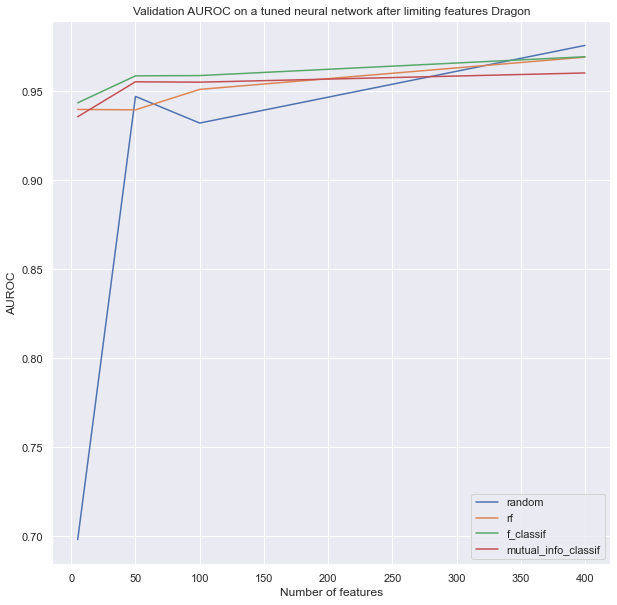

In [193]:
ax = accuracy_2.plot(figsize=(10, 10))
ax.set_title(f"Validation AUROC on a tuned neural network after limiting features {dataset}")
ax.set_xlabel("Number of features")
ax.set_ylabel("AUROC")

In [235]:
import sklearn.feature_selection as fs
from sklearn.feature_selection import VarianceThreshold

# Create a VarianceThreshold object to remove features with zero variance
constant_filter = VarianceThreshold(threshold=0)

# Fit the constant filter on the training data
constant_filter.fit(X_train_t_nn)

# Apply the constant filter to transform the training, validation, and test data
X_train_nn = constant_filter.transform(X_train_nn)
X_test_nn = constant_filter.transform(X_test_nn)
X_val_nn = constant_filter.transform(X_val_nn)
X_train_t_nn = constant_filter.transform(X_train_t_nn)

# Create a SelectKBest object with the f_classif scoring function and select top 100 features    
bk = fs.SelectKBest(fs.f_classif, k=100)

# Fit the SelectKBest object on the training data
bk.fit(X_train_nn, y_train_nn)

# Apply the SelectKBest filter to transform the training, validation, and test data
X_train_nn = bk.transform(X_train_nn)
X_val_nn = bk.transform(X_val_nn)
X_test_nn = bk.transform(X_test_nn)
X_train_t_nn = bk.transform(X_train_t_nn)

Choose f_classif method of feature selection, with 100 features.
### Retune and retrain model

In [123]:
def model_builder_3(hp):

    model = keras.Sequential()
    model.add(Dense(X_train_nn.shape[-1], input_shape=(X_train_nn.shape[-1],), activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

In [124]:
print(X_val_nn.shape)
tuner = kt.Hyperband(model_builder_3,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=40,
                     factor=3,
                     seed=SEED, 
                     directory="results_dir_dragon",
                     project_name="odor",
                     overwrite=True,)
                     
tuner.search(X_train_t_nn, 
             y_train_t_nn, 
             epochs=40,
             callbacks=[early_stopping],
             validation_data=(X_val_nn, y_val_nn))

Trial 90 Complete [00h 00m 07s]
val_auc: 0.9699887633323669

Best val_auc So Far: 0.9714526534080505
Total elapsed time: 00h 05m 15s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [125]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. \n The optimal number of units in the first densely-connected
layer is {best_hps.get('unit_1')} \n The optimal number of units in the second densely-connected
layer is {best_hps.get('unit_2')} \n The optimal number of dropouts in the first densely-connected
layer is {best_hps.get('dropout_1')}.\n The optimal learning 
rate is  {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. 
 The optimal number of units in the first densely-connected
layer is 1282 
 The optimal number of units in the second densely-connected
layer is 1922 
 The optimal number of dropouts in the first densely-connected
layer is 0.15000000000000002.
 The optimal learning 
rate is  0.001



In [126]:
model4 = tuner.hypermodel.build(best_hps)
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 1282)              129482    
                                                                 
 dropout_1 (Dropout)         (None, 1282)              0         
                                                                 
 dense_6 (Dense)             (None, 1922)              2465926   
                                                                 
 dense_7 (Dense)             (None, 1)                 1923      
                                                                 
Total params: 2,607,431
Trainable params: 2,607,431
Non-trainable params: 0
_________________________________________________________________


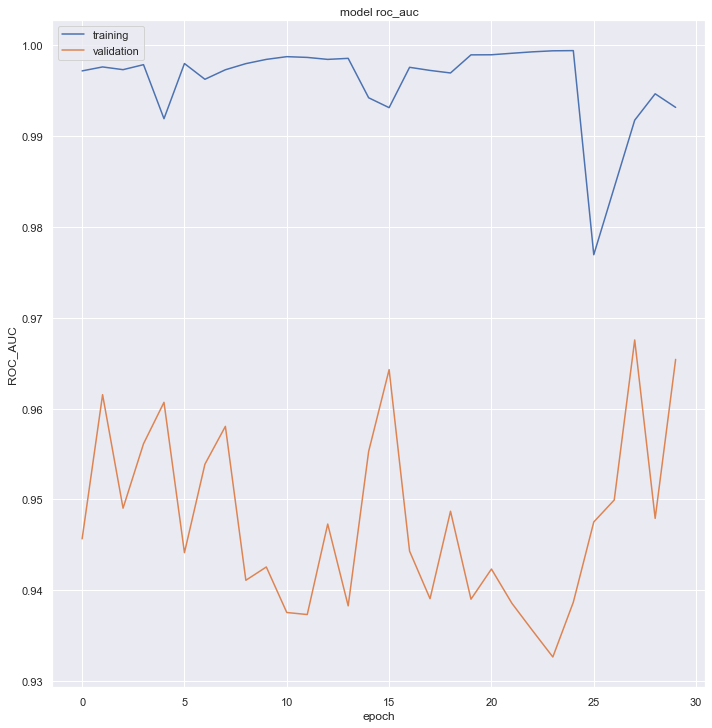

22/22 [==============================] - 0s 3ms/step


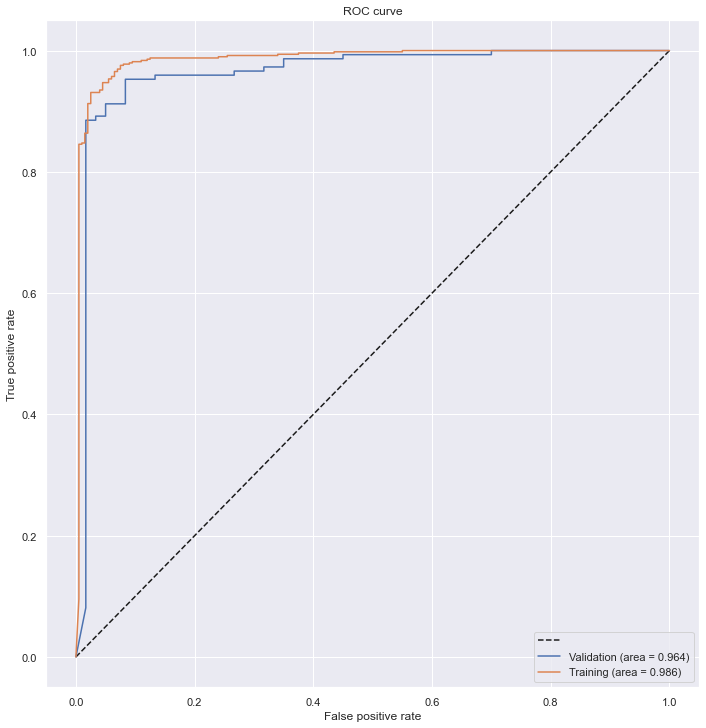

7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        60
           1       0.97      0.95      0.96       148

    accuracy                           0.94       208
   macro avg       0.92      0.93      0.92       208
weighted avg       0.94      0.94      0.94       208



In [145]:
history = model4.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30,
                      callbacks=[early_stopping],
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras_train(model4, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn)

In [158]:
tuned_nn = model4

## Evaluate model on test data

6/6 [==============================] - 0s 3ms/step


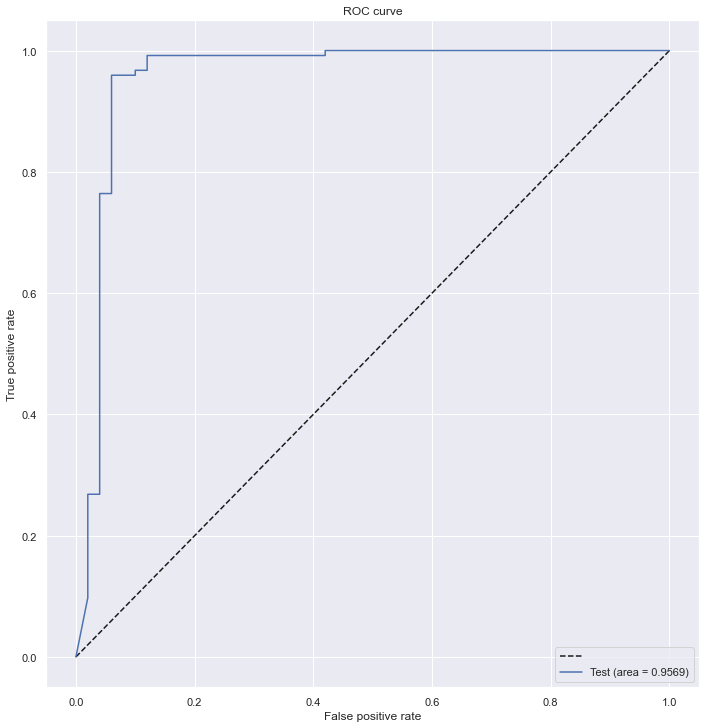

6/6 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0     0.9762    0.8200    0.8913        50
           1     0.9313    0.9919    0.9606       123

    accuracy                         0.9422       173
   macro avg     0.9537    0.9059    0.9260       173
weighted avg     0.9443    0.9422    0.9406       173



In [240]:
test_model_keras(model4, X_test_nn, y_test_nn, X_train_nn, y_train_nn)

# Penalized SVM

In [ ]:
from sklearn import svm

y_train_svm = y_train.copy()
y_test_svm = y_test.copy()
X_train_svm, X_test_svm = handleNaNs(X_train.copy(), X_test.copy(), option=1)

In [ ]:
clf_s = svm.SVC(kernel='linear',
                gamma='scale',
                class_weight='balanced', # penalize
                probability=True)

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

print("Baseline CV=10 training performance of a SVM")

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
# evaluate model
scores = cross_val_score(clf_s, X_train_svm, y_train_svm, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

In [ ]:
print("CV=5 training performance of a SVM with RF most important descriptors")

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
# evaluate model
scores = cross_val_score(clf_s, X_train_rf, y_train_rf, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

In [ ]:
clf_s.fit(X_train_rf, y_train_rf)
test_model(clf_s, y_test_rf, X_test_rf)

# Graphs for all models

In [236]:
# RF
y_pred_rf=tuned_rf.predict(X_test_rf)
y_pred_probs_rf=tuned_rf.predict_proba(X_test_rf)[:,1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test,  y_pred_probs_rf)  
auc_t_rf = metrics.roc_auc_score(y_test, y_pred_probs_rf)

# XGB
y_pred_xgb=tuned_xgb.predict(X_test_xgb)
y_pred_probs_xgb=tuned_xgb.predict_proba(X_test_xgb)[:,1]
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test,  y_pred_probs_xgb) 
auc_t_xgb = metrics.roc_auc_score(y_test, y_pred_probs_xgb)


# Neural network
y_pred_t_keras = tuned_nn.predict(X_test_nn).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_nn, y_pred_t_keras)
auc_t_keras = metrics.roc_auc_score(y_test_nn, y_pred_t_keras)

6/6 [==============================] - 0s 4ms/step


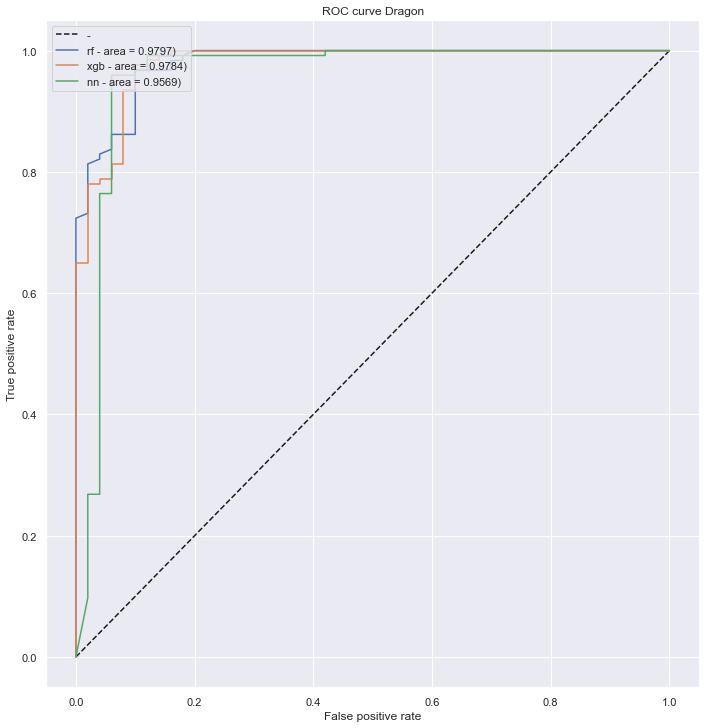

In [237]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf,tpr_rf)
plt.plot(fpr_xgb,tpr_xgb)
plt.plot(fpr_keras, tpr_keras)
plt.title(f'ROC curve {dataset}')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend(['-', 'rf - area = {:.4f})'.format(auc_t_rf), 'xgb - area = {:.4f})'.format(auc_t_xgb), 'nn - area = {:.4f})'.format(auc_t_keras)], loc='upper left')
plt.show()